In [1]:
#### Project 

In [2]:
#### Let's users give their information on the match to be predicted 
team_name = str(input("Enter the team name with the first letter in capital (Arsenal for example): "))
opponent_name = str(input("Enter the oppopnent name with the first letter in capital: "))
stadium = str(input("Enter 1 if team play the match at home and 0 else: "))


Enter the team name with the first letter in capital (Arsenal for example): Arsenal
Enter the oppopnent name with the first letter in capital: Liverpool
Enter 1 if team play the match at home and 0 else: 0


In [3]:
#### Import packages

from bs4 import BeautifulSoup
import urllib3
import re
import time
from collections import defaultdict
import numpy as np
import tqdm
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [4]:
### Let's define the urlpage of the teams statistics for the 2023 championship
urlpage_1 = 'https://www.premierleague.com/tables'

### Let's define the urlpage of the teams statistics for the 2022 championship
urlpage_2 = 'https://fr.besoccer.com/competition/classement/premier/2022'

### Let's define the urlpage of the teams statistics for the 2021 championship
urlpage_3 = 'https://fr.besoccer.com/competition/classement/premier/2021'

### Let's define the urlpage of the teams statistics for the 2020 championship
urlpage_4 = 'https://fr.besoccer.com/competition/classement/premier/2020'

### Let's define the urlpage of the teams results for the 2022 championship
urlpage_5 =  "https://fbref.com/fr/comps/9/2021-2022/calendrier/Calendrier-et-resultats-2021-2022-Premier-League"

### Let's define the urlpage of the teams results for the 2021 championship
urlpage_6 = "https://fbref.com/fr/comps/9/2020-2021/calendrier/Calendrier-et-resultats-2020-2021-Premier-League"

### Let's define the urlpage of the teams results for the 2020 championship
urlpage_7 = "https://fbref.com/fr/comps/9/2019-2020/calendrier/Calendrier-et-resultats-2019-2020-Premier-League"

In [5]:
### Let's define a function to get the web page and subtract the part of the html codes we need (function n°1)

def get_page(urlpage_1,element,html_id):
    # Get page in html
    req = urllib3.PoolManager()
    res = req.request('GET', urlpage_1)
    row_html = BeautifulSoup(res.data, 'html.parser')
    
    # Return elements that matched the html class in a list
    All_leagues = row_html.find_all('main' ,id= "mainContent")
    
    #Split All_championnat to get each championship
    by_league = str(All_leagues).split('<div class="tableCompetitionExplainedContainer"></div>')
    
    #Return elements and class for the current championship (2023)
    Premier_league_23= by_league[0]
    
    return Premier_league_23

In [6]:
### Let's test the function n°1 and change some teams name

Premier_league_23= get_page(urlpage_1,
                        'main', "mainContent")

old_chain_23 = ["Manchester United", "Tottenham Hotspur", "Newcastle United", "Brighton &amp; Hove Albion", "Wolverhampton Wanderers", "West Ham United"]
new_chain_23 = ["Manchester Utd", "Tottenham", "Newcastle Utd", "Brighton", "Wolves", "West Ham"]

# Let"s create a regular expression and use re.escape to escape speficic character
pattern = re.compile("|".join(map(re.escape, old_chain_23)))

# Let's use re.sub to replace the match
Premier_league_23 = pattern.sub(lambda match: new_chain_23[old_chain_23.index(match.group(0))], Premier_league_23)

### List of team in 2023 championship 
list_team_23= re.findall('data-filtered-table-row-name="(.*?)"', str(Premier_league_23))


In [7]:
#### Let's define a function to get informations on each team (function n°2)

def extract_team_23_stats(Premier_league_23, team):
    team_real= team.title()
    pattern = r'data-filtered-table-row-name="{}"'.format(team_real)
    match = re.search(pattern, Premier_league_23)
    start= match.start()
    end = Premier_league_23.index('<tr class="expandable"', start)
    team_data_23 = Premier_league_23[start:end]
    
    position = int(re.findall('data-position="(.*?)">', str(team_data_23))[0])
    data =  re.findall(r'<td.*?>(\d+)<\/td>', team_data_23)
    match_played =int(data[0].strip('<td>').strip('</td>'))
    points = int(re.search(r'<td class="points">\d+</td>', team_data_23).group().strip('<td class="points">').strip('</td>'))
    wins = int(data[1].strip('<td>').strip('</td>'))
    loses = int(data[3].strip('<td>').strip('</td>'))
    drawns = int(data[2].strip('<td>').strip('</td>'))
    goals_for= int(data[4].strip('<td>').strip('</td>'))
    goals_against= int(data[5].strip('<td>').strip('</td>'))

    team_stats = {'position': position,'match_played': match_played,'points': points,'wins': wins,'loses': loses,'drawns': drawns,'goals_for': goals_for,
        'goals_against': goals_against
    }

    return team_stats

In [8]:
## Let's test function n° 2 and produce team statistics on independant variables for 2023 championship

# Let's initialise a dictionary
team_stats_23 = {}

# We perform a loop over teams
for team in list_team_23:
    # Get team statistics with the function n°2
    team_stats = extract_team_23_stats(Premier_league_23, team)
    
    # Convert team statistics to a dataframe
    team_stats_df = pd.DataFrame(team_stats, index=[0])
    
    # Create a team name and year variable in the dataframe
    team_stats_df['team'] = team
    team_stats_df['year'] = 2023
    
    # Let's add the dataframe to the dictionnary (note that teams are like keys of this dictionnary)
    team_stats_23[team] = team_stats_df
    
# Let's concatenate all dataframes in the dictionnary to a single dataframe (we put index=T to not have zero on each line)
x_predict = pd.concat(team_stats_23.values(), ignore_index=True)

### For order
x_predict = x_predict.reindex(columns=['year','team', 'match_played', 'position', 
                                                   'points', 'wins', 'loses', 'drawns',
                                       
                                                  'goals_for', 'goals_against'])

In [9]:
### Function 2b  to get statistics on independant variables for teams
def get_X_predict (team, opponent):
    teams=[team, opponent]
    df_final = x_predict[x_predict["team"].isin(teams)]
    df_final[["match_played", "position", "points", "wins", "loses",
    "drawns", "goals_for", "goals_against"]] = df_final[["match_played", "position", "points", "wins", "loses",
                                                  "drawns", "goals_for", "goals_against"]].apply(lambda x: x.diff())
    df_final= df_final.iloc[1]
    df_final = pd.DataFrame(df_final)
    df_final = df_final.transpose()
    df_final = df_final.rename(columns={'team': 'opponent'})
    df_final['team'] = teams[0]
    df_final['stadium'] = stadium
    df_final= df_final.set_index(["year", "team", "opponent"])
    var_order = ['stadium','match_played', 'position', 'points', 
                 'wins', 'loses', 'drawns', 'goals_for', 'goals_against']
    X_predict = df_final.reindex(columns = var_order)          
    
    
    return X_predict

In [10]:
X_predict = get_X_predict (team_name, opponent_name)

C:\Users\RAZAFIMANANTENA\AppData\Local\Temp\ipykernel_6584\1061147806.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[["match_played", "position", "points", "wins", "loses",


In [11]:
### Let's define a function to get the web page and subtract the part of the html codes we need (function n°3)

def get_page(urlpage_2,element,html_class):
    # Get page in html
    req_3 = urllib3.PoolManager()
    res_3 = req_3.request('GET', urlpage_2)
    row_html_3 = BeautifulSoup(res_3.data, 'html.parser')
    
    # Return elements that matched the html class in a list
    Premier_league_22 = row_html_3.find_all(element , class_= html_class)
    return(Premier_league_22)

In [12]:
#Let's test the function n°3 and change some teams name

Premier_league_22= str(get_page(urlpage_2, 'tr', 'row-body'))

old_chain_22 = ["Man. City","Tottenham Hotspur", "Man. Utd", "Leicester", "Brighton &amp; Hove Albion"]
new_chain_22 = ["Manchester City", "Tottenham", "Manchester Utd", "Leicester City", "Brighton"]

# Let"s create a regular expression and use re.escape to escape speficic character
pattern = re.compile("|".join(map(re.escape, old_chain_22)))

# Let's use re.sub to replace the match
Premier_league_22 = pattern.sub(lambda match: new_chain_22[old_chain_22.index(match.group(0))], Premier_league_22)

### List of team in 2022 championship 
list_team_22 = re.findall('<span class="team-name">(.*?)</span>', str(Premier_league_22))



In [13]:
###Let's define a function to get informations on each team (function n°4)

def extract_team_22_stats(Premier_league_22, team):
    team= team.title()
    position= (list_team_22.index(team)+1)
    start = Premier_league_22.find(team)
    end = Premier_league_22.index("</tr>", start)
    team_data_22 = Premier_league_22[start:end]
    
    match_played= 38
    data = [int(s) for s in re.findall(r'<td.*?>(\d+)</td>', team_data_22)]
    points= data[0]
    wins= data [1]
    drawns= data [2]
    loses =data [3]
    goals_for = data [4]
    goals_against = data [5]

    team_stats22 = {'match_played': match_played,'position': position,'points': points,
                    'wins': wins,'loses': loses ,'drawns':  drawns,'goals_for': goals_for,
        'goals_against':goals_against
    }

    return team_stats22

In [14]:
## Let's test function n° 4 and produce team statistics on independant variables for 2022 championship

# Let's initialise a dictionary
team_stats_22 = {}

# We perform a loop over teams
for team in list_team_22:
    # Get team statistics with the function n°4
    team_stats = extract_team_22_stats(Premier_league_22, team)
    
    # Convert team statistics to a dataframe
    team_stats_df = pd.DataFrame(team_stats, index=[0])
    
    # Create a team name variable in the dataframe
    team_stats_df['team'] = team
    team_stats_df['year'] = 2022
    
    # Let's add the dataframe to the dictionnary (note that teams are like keys of this dictionnary)
    team_stats_22[team] = team_stats_df
    
# Let's concatenate all dataframes in the dictionnary to a single dataframe (we put index=T to not have zero on each line)
data_on_stats_22 = pd.concat(team_stats_22.values(), ignore_index=True)

### For order
data_on_stats_22 = data_on_stats_22.reindex(columns=['year','team', 'match_played', 'position', 
                                                   'points', 'wins', 'loses', 'drawns',
                                                  'goals_for', 'goals_against'])

In [15]:
### Let's define a function to get the web page and subtract the part of the html codes we need (function n°5)

def get_page(urlpage_3,element,html_class):
    # Get page in html
    req_4 = urllib3.PoolManager()
    res_4 = req_4.request('GET', urlpage_3)
    row_html_4 = BeautifulSoup(res_4.data, 'html.parser')
    
    # Return elements that matched the html class in a list
    Premier_league_21 = row_html_4.find_all(element , class_= html_class)
    return(Premier_league_21)

In [16]:
#Let's test the function n°5 and change some teams name

Premier_league_21= str(get_page(urlpage_3, 'tr', 'row-body'))

old_chain_21 = ["Man. City","Tottenham Hotspur", "Man. Utd", "Leicester", "Brighton &amp; Hove Albion", "West Bromwich Albion",
               "Sheffield United"]
new_chain_21 = ["Manchester City", "Tottenham", "Manchester Utd", "Leicester City", "Brighton", "West Brom", "Sheffield Utd"]

# Let"s create a regular expression and use re.escape to escape speficic character
pattern = re.compile("|".join(map(re.escape, old_chain_21)))

# Let's use re.sub to replace the match
Premier_league_21 = pattern.sub(lambda match: new_chain_21[old_chain_21.index(match.group(0))], Premier_league_21)

### List of team in 2022 championship 
list_team_21 = re.findall('<span class="team-name">(.*?)</span>', str(Premier_league_21))



In [17]:
###Let's define a function to get informations on each team (function n°6)

def extract_team_21_stats(Premier_league_21, team):
    team= team.title()
    position= (list_team_21.index(team)+1)
    start = Premier_league_21.find(team)
    end = Premier_league_21.index("</tr>", start)
    team_data_21 = Premier_league_21[start:end]
    
    match_played= 38
    data = [int(s) for s in re.findall(r'<td.*?>(\d+)</td>', team_data_21)]
    points= data[0]
    wins= data [1]
    drawns= data [2]
    loses =data [3]
    goals_for = data [4]
    goals_against = data [5]

    team_stats21 = {'match_played': match_played,'position': position,'points': points,
                    'wins': wins,'loses': loses ,'drawns':  drawns,'goals_for': goals_for,
        'goals_against':goals_against
    }

    return team_stats21

In [18]:
## Let's test function 6 and produce team statistics on independant variables for 2021 championship

# Let's initialise a dictionary
team_stats_21 = {}

# We perform a loop over teams
for team in list_team_21:
    # Get team statistics with the function n°6
    team_stats = extract_team_21_stats(Premier_league_21, team)
    
    # Convert team statistics to a dataframe
    team_stats_df = pd.DataFrame(team_stats, index=[0])
    
    # Create a team name variable in the dataframe
    team_stats_df['team'] = team
    team_stats_df['year'] = 2021
    
    # Let's add the dataframe to the dictionnary (note that teams are like keys of this dictionnary)
    team_stats_21[team] = team_stats_df
    
# Let's concatenate all dataframes in the dictionnary to a single dataframe (we put index=T to not have zero on each line)
data_on_stats_21 = pd.concat(team_stats_21.values(), ignore_index=True)

### For order
data_on_stats_21 = data_on_stats_21.reindex(columns=['year','team', 'match_played', 'position', 
                                                   'points', 'wins', 'loses', 'drawns',
                                                  'goals_for', 'goals_against'])

In [19]:
### Let's define a function to get the web page and subtract the part of the html codes we need (function n°7)

def get_page(urlpage_4,element,html_class):
    # Get page in html
    req_5 = urllib3.PoolManager()
    res_5 = req_5.request('GET', urlpage_4)
    row_html_5 = BeautifulSoup(res_5.data, 'html.parser')
    
    # Return elements that matched the html class in a list
    Premier_league_20 = row_html_5.find_all(element , class_= html_class)
    return(Premier_league_20)

In [20]:
#Let's test the function n°7 and change some teams name

Premier_league_20= str(get_page(urlpage_4, 'tr', 'row-body'))

old_chain_20 = ["Man. City","Tottenham Hotspur", "Man. Utd", "Leicester", "Brighton &amp; Hove Albion", "AFC Bournemouth",
               "Sheffield United"]
new_chain_20 = ["Manchester City", "Tottenham", "Manchester Utd", "Leicester City", "Brighton", "Bournemouth", "Sheffield Utd"]

# Let"s create a regular expression and use re.escape to escape speficic character
pattern = re.compile("|".join(map(re.escape, old_chain_20)))

# Let's use re.sub to replace the match
Premier_league_20 = pattern.sub(lambda match: new_chain_20[old_chain_20.index(match.group(0))], Premier_league_20)

### List of team in 2022 championship 
list_team_20 = re.findall('<span class="team-name">(.*?)</span>', str(Premier_league_20))



In [21]:
###Let's define a function to get informations on each team (function n°8)

def extract_team_20_stats(Premier_league_20, team):
    team= team.title()
    teams = re.findall('<span class="team-name">(.*?)</span>', str(Premier_league_20))
    position= (list_team_20.index(team)+1)
    start = Premier_league_20.find(team)
    end = Premier_league_20.index("</tr>", start)
    team_data_20 = Premier_league_20[start:end]
    
    match_played= 38
    data = [int(s) for s in re.findall(r'<td.*?>(\d+)</td>', team_data_20)]
    points= data[0]
    wins= data [1]
    drawns= data [2]
    loses =data [3]
    goals_for = data [4]
    goals_against = data [5]

    team_stats20 = {'match_played': match_played,'position': position,'points': points,
                    'wins': wins,'loses': loses ,'drawns':  drawns,'goals_for': goals_for,
        'goals_against':goals_against
    }

    return team_stats20

In [22]:
## Let's test function n° 8 and produce team statistics on independant variables for 2021 championship

# Let's initialise a dictionary
team_stats_20 = {}

# We perform a loop over teams
for team in list_team_20:
    # Get team statistics with the function n°8
    team_stats = extract_team_20_stats(Premier_league_20, team)
    
    # Convert team statistics to a dataframe
    team_stats_df = pd.DataFrame(team_stats, index=[0])
    
    # Create a team name variable in the dataframe
    team_stats_df['team'] = team
    team_stats_df['year'] = 2020
    
    # Let's add the dataframe to the dictionnary (note that teams are like keys of this dictionnary)
    team_stats_20[team] = team_stats_df
    
# Let's concatenate all dataframes in the dictionnary to a single dataframe (we put index=T to not have zero on each line)
data_on_stats_20 = pd.concat(team_stats_20.values(), ignore_index=True)

### For order
data_on_stats_20 = data_on_stats_20.reindex(columns=['year','team', 'match_played', 'position', 
                                                   'points', 'wins', 'loses', 'drawns',
                                                  'goals_for', 'goals_against'])

In [23]:
####  Let's define a function to get the information about the team's match results (function n°9)

def get_team_matches_22(team_name):
    team_name= team_name.title()
    all_tables = pd.read_html(urlpage_5)
    tables = all_tables[0]
    tables_index = tables.set_index("Sem.")
    tt = tables_index.loc[:, ["Domicile", "Score", "Extérieur"]]
    tt['Résultat'] = np.where(tt["Domicile"] == team_name,
                              ['wins' if (isinstance(score, str) and int(score.split('–')[0]) > int(score.split('–')[1])) 
                               else 'drawns' if (isinstance(score, str) and int(score.split('–')[0]) == int(score.split('–')[1])) 
                               else 'loses' if isinstance(score, str) else np.nan for score in tt['Score']],
                              ['wins' if (isinstance(score, str) and int(score.split('–')[1]) > int(score.split('–')[0])) 
                               else 'drawns' if (isinstance(score, str) and int(score.split('–')[1]) == int(score.split('–')[0])) 
                               else 'loses' if isinstance(score, str) else np.nan for score in tt['Score']]
                             
                             )
    team_matches = tt.loc[(tt["Domicile"] == team_name) | (tt["Extérieur"] == team_name)]
    team_matches["Lieux"]= np.where(team_matches["Domicile"]== team_name, "home", "away")
    
    team_matches.loc[team_matches["Extérieur"] == team_name, "Extérieur"] = team_matches["Domicile"]
    team_matches.loc[team_matches["Domicile"] != team_name, "Domicile"] = team_name
    
    team_matches = team_matches.loc[:, ["Domicile", "Extérieur", "Résultat", "Lieux"]]
    team_matches = team_matches.rename(columns= {'Domicile': 'team', 'Extérieur': 'opponent', 
                                                 'Résultat': 'result_team', 'Lieux': 'stadium'})
    return team_matches

In [24]:
### Let's test function n°9

team_matches_22 = get_team_matches_22(team_name)


C:\Users\RAZAFIMANANTENA\AppData\Local\Temp\ipykernel_6584\159749620.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_matches["Lieux"]= np.where(team_matches["Domicile"]== team_name, "home", "away")


In [25]:
#### Let's define a function to get the information about the team's match results (function n°10)

def get_team_matches_21(team_name):
    team_name= team_name.title()
    all_tables = pd.read_html(urlpage_6)
    tables = all_tables[0]
    tables_index = tables.set_index("Sem.")
    tt = tables_index.loc[:, ["Domicile", "Score", "Extérieur"]]
    tt['Résultat'] = np.where(tt["Domicile"] == team_name,
                              ['wins' if (isinstance(score, str) and int(score.split('–')[0]) > int(score.split('–')[1])) 
                               else 'drawns' if (isinstance(score, str) and int(score.split('–')[0]) == int(score.split('–')[1])) 
                               else 'loses' if isinstance(score, str) else np.nan for score in tt['Score']],
                              ['wins' if (isinstance(score, str) and int(score.split('–')[1]) > int(score.split('–')[0])) 
                               else 'drawns' if (isinstance(score, str) and int(score.split('–')[1]) == int(score.split('–')[0])) 
                               else 'loses' if isinstance(score, str) else np.nan for score in tt['Score']]
                             )
    team_matches = tt.loc[(tt["Domicile"] == team_name) | (tt["Extérieur"] == team_name)]
    team_matches["Lieux"]= np.where(team_matches["Domicile"]== team_name, "home", "away")
    
    team_matches.loc[team_matches["Extérieur"] == team_name, "Extérieur"] = team_matches["Domicile"]
    team_matches.loc[team_matches["Domicile"] != team_name, "Domicile"] = team_name
    
    team_matches = team_matches.loc[:, ["Domicile", "Extérieur", "Résultat", "Lieux"]]
    team_matches = team_matches.rename(columns= {'Domicile': 'team', 'Extérieur': 'opponent', 
                                                 'Résultat': 'result_team', 'Lieux': 'stadium'})
    return team_matches

In [26]:
#### Let's test function n°10

team_matches_21 = get_team_matches_21(team_name)


C:\Users\RAZAFIMANANTENA\AppData\Local\Temp\ipykernel_6584\1580486685.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_matches["Lieux"]= np.where(team_matches["Domicile"]== team_name, "home", "away")


In [27]:
### Let's define a function to get the information about the team's match results (function n°11)

def get_team_matches_20(team_name):
    team_name= team_name.title()
    all_tables = pd.read_html(urlpage_7)
    tables = all_tables[0]
    tables_index = tables.set_index("Sem.")
    tt = tables_index.loc[:, ["Domicile", "Score", "Extérieur"]]
    tt['Résultat'] = np.where(tt["Domicile"] == team_name,
                              ['wins' if (isinstance(score, str) and int(score.split('–')[0]) > int(score.split('–')[1])) 
                               else 'drawns' if (isinstance(score, str) and int(score.split('–')[0]) == int(score.split('–')[1])) 
                               else 'loses' if isinstance(score, str) else np.nan for score in tt['Score']],
                              ['wins' if (isinstance(score, str) and int(score.split('–')[1]) > int(score.split('–')[0])) 
                               else 'drawns' if (isinstance(score, str) and int(score.split('–')[1]) == int(score.split('–')[0])) 
                               else 'loses' if isinstance(score, str) else np.nan for score in tt['Score']]
                             )
    team_matches = tt.loc[(tt["Domicile"] == team_name) | (tt["Extérieur"] == team_name)]
    team_matches["Lieux"]= np.where(team_matches["Domicile"]== team_name, "home", "away")
    
    team_matches.loc[team_matches["Extérieur"] == team_name, "Extérieur"] = team_matches["Domicile"]
    team_matches.loc[team_matches["Domicile"] != team_name, "Domicile"] = team_name
    
    team_matches = team_matches.loc[:, ["Domicile", "Extérieur", "Résultat", "Lieux"]]
    team_matches = team_matches.rename(columns= {'Domicile': 'team', 'Extérieur': 'opponent', 
                                                 'Résultat': 'result_team', 'Lieux': 'stadium'})
    return team_matches

In [28]:
### Let's test function n°11

team_matches_20 = get_team_matches_20(team_name)
team_matches_20


C:\Users\RAZAFIMANANTENA\AppData\Local\Temp\ipykernel_6584\1884334968.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_matches["Lieux"]= np.where(team_matches["Domicile"]== team_name, "home", "away")


,team,opponent,result_team,stadium
Sem.,,,,
1.0,Arsenal,Newcastle Utd,wins,away
2.0,Arsenal,Burnley,wins,home
3.0,Arsenal,Liverpool,loses,away
4.0,Arsenal,Tottenham,drawns,home
5.0,Arsenal,Watford,drawns,away
6.0,Arsenal,Aston Villa,wins,home
7.0,Arsenal,Manchester Utd,drawns,away
8.0,Arsenal,Bournemouth,wins,home
9.0,Arsenal,Sheffield Utd,loses,away


In [29]:
# Let's put the years considered
years = [2020, 2021, 2022]

# Let's create a list of dataframe
results = [team_matches_20, team_matches_21, team_matches_22]

# And let's apply the transformattion for each dataframe 
for i, results_frame in enumerate(results):
    results_frame['stadium'] = results_frame['stadium'].replace({'away': 0, 'home': 1})
    results_frame['year'] = years[i]
    results_frame = results_frame.reindex(columns=['year', 'team', 'opponent', 'stadium', 'result_team'])
    results[i] = results_frame

# Concaténation des dataframes
y_stats = pd.concat(results)

#### Let's combine team statistics on independant variables into a same dataframe for X train
x_stats = pd.concat([data_on_stats_20, data_on_stats_21, data_on_stats_22])


In [30]:
#### Let's combine all training data in a single dataframe

y_stats.reset_index(drop=True) ## drop y_train index
y_stats.set_index(['year','team']) ## Set two new index
x_stats.set_index(['year','team']) ## Set two new index

base_train = pd.merge(y_stats, x_stats, how= 'inner', on = ['year', 'team'])  ## merge y_stats and x_stats for team statistics

base_train = base_train.rename(columns={'team':'opponent', 'opponent': 'team' }) ## rename columns for a second merge
base_train = pd.merge(base_train, x_stats, how= 'inner', on = ['year', 'team'])  ## merge base_train and x_stats for opponent stats

base_train = base_train.rename(columns={'opponent':'team', 'team': 'opponent' }) ## rename in as original data

In [31]:
#### Let's create the difference variables for independant variables  
base_train_2 = base_train.assign(match_played= base_train['match_played_y']- base_train['match_played_x'],
                                position= base_train['position_y']- base_train['position_x'], 
                                points= base_train['points_y'] - base_train['points_x'],
                                wins= base_train['wins_y'] - base_train['wins_x'],
                                loses= base_train['loses_y'] - base_train['loses_x'],
                                drawns= base_train['drawns_y'] - base_train['drawns_x'],
                                goals_for= base_train['goals_for_y'] - base_train['goals_for_x'],
                                goals_against= base_train['goals_against_y'] - base_train['goals_against_x'])

#### Create new dataframe for difference variables
base_esti = base_train_2.loc[:, ["year", "team", "opponent", "result_team", "stadium", "match_played", "position", 
                                 "points", "wins", "loses", "drawns", "goals_for", "goals_against"]]

## Create the final training dataframe putting year, team and opponent variables in index
base_training= base_esti.set_index(["year", "team", "opponent"])

In [32]:
# Divised base_training in training and test data
X = base_training.drop(["result_team"], axis=1)
y = base_training["result_team"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
#### Create a multinomial model 
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
### Let's get the probability for the result of team
probability = model.predict_proba(X_predict)
percentages = [p*100 for p in probability]
class_names = model.classes_
print (percentages, class_names)

[array([17.45886596, 34.08013284, 48.4610012 ])] ['drawns' 'loses' 'wins']


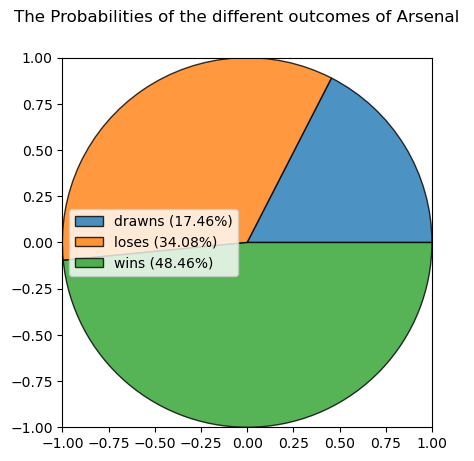

In [35]:
# Create a list of colors with a different color for each class
colors = ['C0', 'C1', 'C2']

# Create a figure with a single subplot
fig, ax = plt.subplots()

# Set the aspect ratio of the subplot to be equal, so that it becomes a circle
ax.set_aspect('equal')

# Set the limits of the plot to be from -1 to 1 in both the x and y directions
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Set the angle at which the first wedge starts
current_angle = 0

# Loop through each class and create a wedge with the corresponding color
for i in range(len(class_names)):
    
    # Get the probability for the current class
    current_prob = probability[0][i]
    
    # Calculate the angle of the current wedge based on the probability
    current_angle += current_prob * 360
    
    # Create a wedge with the start and end angles and the corresponding color
    wedge = patches.Wedge((0, 0), 1, current_angle - current_prob * 360, current_angle, edgecolor='black', facecolor=colors[i], alpha=0.8)
    
    # Add the wedge to the subplot
    ax.add_patch(wedge)

# Add a legend to the plot with the class names and probabilities
ax.legend(labels=[f"{class_names[i]} ({percentages[0][i]:.2f}%)" for i in range(len(class_names))], loc='center left')

fig.suptitle(f"The Probabilities of the different outcomes of {team_name} ") ### Add a title 

# Display the plot
plt.show()